# import necessary library

In [1]:
# for garbage collection
import gc

# for warnings
import warnings
warnings.filterwarnings("ignore")

# utility libraries
import os
import copy
import tqdm
import numpy as np 
import pandas as pd 
import cv2, random, time, shutil, csv
import tensorflow as tf 
import math
import time
from util import *

# keras libraries
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D, Lambda, Dropout, InputLayer, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

In [2]:
# checking if GPU is being used for training
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("GPU is not detected")

Default GPU Device:/device:GPU:0


# prepare of data set


In [3]:
# loading labels from csv file
data_dir = os.path.join(os.getcwd(), 'Datasets')
data_df = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
breeds = sorted(data_df.breed.unique())

print(f"Shape\t\t: {data_df.shape}")
print(f"Unique labels\t: {len(breeds)}")

Shape		: (10222, 2)
Unique labels	: 120


In [4]:
# hyperparameters
img_size = 299
batch_size=128
epochs=80

In [5]:
# load images data
def loadData():
    images_list = sorted(os.listdir(os.path.join(data_dir, 'train')))
    X = []
    Y = []
    for image in tqdm.tqdm(images_list):
        # find matching label
        breed = data_df[data_df['id'] == image[:-4]].iloc[0,1]
        breed_index = int(breeds.index(breed)) 

        # reading image data
        image_path = os.path.join(data_dir, 'train', image)
        res_image = load_img(image_path, target_size=(img_size, img_size))
        res_image = np.asarray(res_image)
        X.append(res_image)
        Y.append(breed_index)
    return X, Y

In [6]:
saving_path = os.path.join(data_dir, f'data_resized{img_size}x{img_size}.h5')


t = time.time()
if (os.path.isfile(saving_path)):
    X, Y = load_h5_data(saving_path)
else:
    X, Y = loadData()
    generate_h5_data(X, Y, saving_path)
print(f'Time taken: {time.time()-t}')


Time taken: 3.5402355194091797


In [7]:
# Converting to arrays
print(len(X), len(Y))
assert(len(X)==len(Y))
Xarr = np.array(X)
Yarr = np.array(Y).reshape(-1,1)

del(X)
print(Xarr.shape, Yarr.shape)
gc.collect()

10222 10222
(10222, 299, 299, 3) (10222, 1)


110

In [8]:
# print out shape, dtype and data size
nparray_info("\nXarr", Xarr)
nparray_info("\nYarr", Yarr)


Xarr
-  shape	 (10222, 299, 299, 3)
-  dtype	 uint8
- nbytes	 2741571066 (2.55 GB)

Yarr
-  shape	 (10222, 1)
-  dtype	 int32
- nbytes	 40888 (39.93 KB)


In [9]:
# converting labels to one hot
Yarr_hot = to_categorical(Y)
print(Xarr.shape, Yarr_hot.shape)

(10222, 299, 299, 3) (10222, 120)


# Feature Extraction

In [10]:
# FEATURE EXTRACTION OF TRAINING ARRAYS
AUTO = tf.data.experimental.AUTOTUNE
def get_features(model_name, data_preprocessor, data):
    '''
    1- Create a feature extractor to extract features from the data.
    2- Returns the extracted features and the feature extractor.
    '''
    dataset = tf.data.Dataset.from_tensor_slices(data)


    def preprocess(x):
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_brightness(x, 0.5)
        return x

    ds = dataset.map(preprocess, num_parallel_calls=AUTO).batch(64)

    input_size = data.shape[1:]
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)

    base_model = model_name(weights='imagenet', include_top=False,
                                input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)


    #Extract feature.
    feature_maps = feature_extractor.predict(ds, verbose=1)
    nparray_info("Feature maps", feature_maps)
    
    # deleting variables
    del(feature_extractor, base_model, preprocessor, dataset)
    gc.collect()
    return feature_maps

In [11]:
# FEATURE EXTRACTION OF VALIDAION AND TESTING ARRAYS
def get_valfeatures(model_name, data_preprocessor, data):
    '''
    Same as above except not image augmentations applied.
    Used for feature extraction of validation and testing.
    '''

    dataset = tf.data.Dataset.from_tensor_slices(data)

    ds = dataset.batch(64)

    input_size = data.shape[1:]
    #Prepare pipeline.
    input_layer = Input(input_size)
    preprocessor = Lambda(data_preprocessor)(input_layer)

    base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)

    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    #Extract feature.
    feature_maps = feature_extractor.predict(ds, verbose=1)
    nparray_info("Feature maps", feature_maps)
    return feature_maps

In [12]:
# generate feature dictionary 
def generate_model_features(feat_func, model_names, models, preprocs, array):
    print(f"Beggining extraction with {feat_func.__name__}\n")
    feats_dict = {}

    for i in range(len(models)):
        print(f"\nStarting feature extraction with {models[i].__name__} using {preprocs[i].__name__}\n")
        # applying the above function and storing in list
        feats_dict[model_names[i]] = feat_func(models[i], preprocs[i], array)
        
    # memory saving
    del(array)
    gc.collect()
    return feats_dict

In [13]:
# RETURNING CONCATENATED FEATURES
def get_concat_features(model_names, feats_dict, verbose=False):
    feats_list = []
    
    for name in model_names:
        if verbose:
            print(f"collect features for {name}...")
        feats_list.append( feats_dict[name] )

    # features concatenating
    final_feats = np.concatenate(feats_list, axis=-1)
    # memory saving
    del(feats_list)
    gc.collect()
    return final_feats

In [14]:
# DEFINING models and preprocessors imports
from tensorflow.keras.applications.xception import Xception, preprocess_input
xception_preprocessor = preprocess_input
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
densenet_preprocessor = preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
inc_resnet_preprocessor = preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input 
mobilenet_preprocessor = preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
inception_preprocessor = preprocess_input
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
restnet_preprocessor = preprocess_input


# collecting top 6 models' features for evaluation later
model_names = ["Xception", "DenseNet169", "InceptionResNetV2", "MobileNet", "InceptionV3", "RestNet50"]
models = [Xception, DenseNet169, InceptionResNetV2, MobileNet, InceptionV3, ResNet50 ]
preprocs = [xception_preprocessor, densenet_preprocessor, inc_resnet_preprocessor, 
            mobilenet_preprocessor, inception_preprocessor, restnet_preprocessor]

## Collecting Features
```python
train_models = model_names[:3]    
final_train_features = get_concat_features(train_models, feats_dict)
nparray_info("Final feature maps", final_train_features)
gc.collect()
```

In [15]:
# Perform feature extraction and save as h5 file
saving_path = os.path.join(data_dir, f'features.h5')

t = time.time()
if (os.path.isfile(saving_path)):
    feats_dict = load_features_data(saving_path)
else:
    feats_dict = generate_model_features(get_features, model_names, models, preprocs, Xarr)
    generate_features_data(feats_dict, saving_path)
gc.collect()
print(f'Time taken: {time.time()-t}')

features loaded
Time taken: 0.5241007804870605


In [16]:
for name in feats_dict:
    nparray_info(name, feats_dict[name])

DenseNet169
-  shape	 (10222, 1664)
-  dtype	 float32
- nbytes	 68037632 (64.89 MB)
InceptionResNetV2
-  shape	 (10222, 1536)
-  dtype	 float32
- nbytes	 62803968 (59.89 MB)
InceptionV3
-  shape	 (10222, 2048)
-  dtype	 float32
- nbytes	 83738624 (79.86 MB)
MobileNet
-  shape	 (10222, 1024)
-  dtype	 float32
- nbytes	 41869312 (39.93 MB)
RestNet50
-  shape	 (10222, 2048)
-  dtype	 float32
- nbytes	 83738624 (79.86 MB)
Xception
-  shape	 (10222, 2048)
-  dtype	 float32
- nbytes	 83738624 (79.86 MB)


## Model Construction

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=0)

my_callback=[EarlyStop_callback]

In [18]:
from sklearn.model_selection import StratifiedKFold

def kfold_split(X, Y_hot, train_idx, valid_idx):
    x_train_fold = X[train_idx, :]
    y_train_fold = Y_hot[train_idx, :]
    x_val_fold = X[valid_idx]
    y_val_fold = Y_hot[valid_idx, :]
    return x_train_fold, y_train_fold, x_val_fold, y_val_fold

# construct model
def buildModel(input_size):
    dnn = keras.models.Sequential([
        InputLayer(input_size),
        Dropout(0.9),
        Dense(120, activation='softmax')
    ])

    dnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return dnn

def trainModels(X, Y, plot_model=True):
    # Use K fold of 5, to ensure train:validation is 80:20
    splits = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=10).split(X, Y))

    trained_models = []
    val_accuracy = []
    val_losses = []
    train_accuracy = []
    train_losses = []

    #Prepare And Train DNN model
    for i, (train_idx, valid_idx) in enumerate(splits): 
        print(f"\nStarting fold {i+1}")
        x_train_fold, y_train_fold, x_val_fold, y_val_fold = kfold_split(X, Yarr_hot, train_idx, valid_idx)

        dnn = buildModel(X.shape[1:])
        print("Training...")
        #Train simple DNN on extracted features.
        h = dnn.fit(x_train_fold, y_train_fold,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data = (x_val_fold, y_val_fold),
                    callbacks=my_callback)
        
        print("Evaluating model ...")
        model_res_val = dnn.evaluate(x_val_fold, y_val_fold)
        model_res_train = dnn.evaluate(x_train_fold, y_train_fold)
        train_accuracy.append(model_res_train[1])
        train_losses.append(model_res_train[0])
        val_accuracy.append(model_res_val[1])
        val_losses.append(model_res_val[0])
        trained_models.append(dnn)
        if (plot_model):
            plot_model_history(h, saving_name=f"fold_{i+1}_LA")

    print('\nCV Score')
    print(f"TrainAccuracy \tavg: {avg(train_accuracy):.5f} \tmax: {max(train_accuracy):.5f}")
    print(f"TrainLoss \tavg: {avg(train_losses):.5f} \tmin: { min(train_losses):.5f}")
    print(f"ValAccuracy \tavg: {avg(val_accuracy):.5f} \tmax: {max(val_accuracy):.5f}")
    print(f"ValLoss \tavg: {avg(val_losses):.5f} \tmin: {min(val_losses):.5f}\n")
    return trained_models, val_accuracy, val_losses, train_accuracy, train_losses


Feature extractions for ['Xception', 'DenseNet169', 'InceptionResNetV2']

Starting fold 1
Training...
Evaluating model ...
256/256 [==============================] - 1s 2ms/step - loss: 0.1540 - accuracy: 0.9521


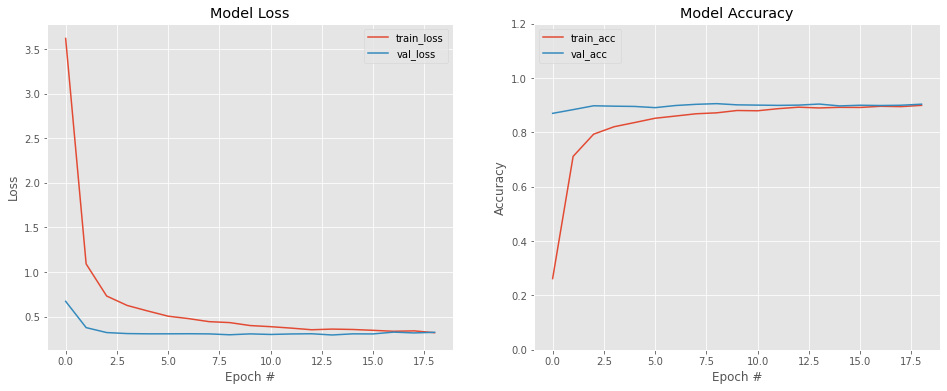


Starting fold 2
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1548 - accuracy: 0.9527


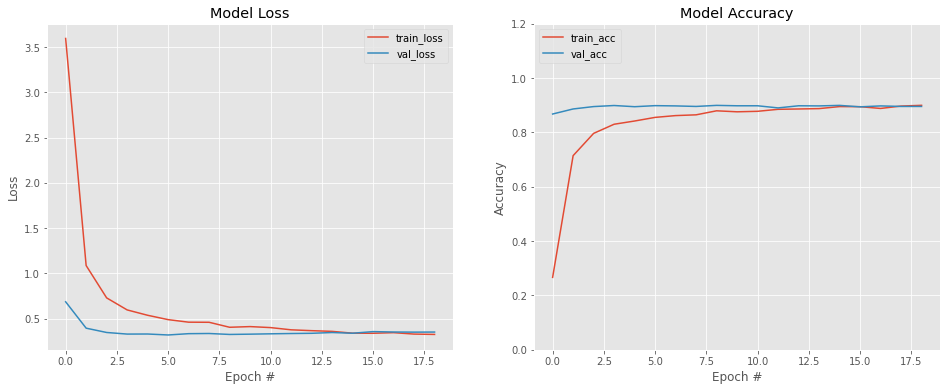


Starting fold 3
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1371 - accuracy: 0.9550


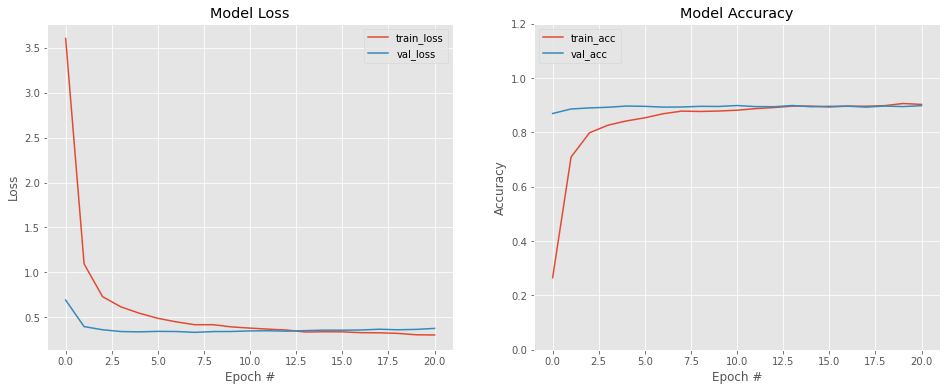


Starting fold 4
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0942 - accuracy: 0.9664


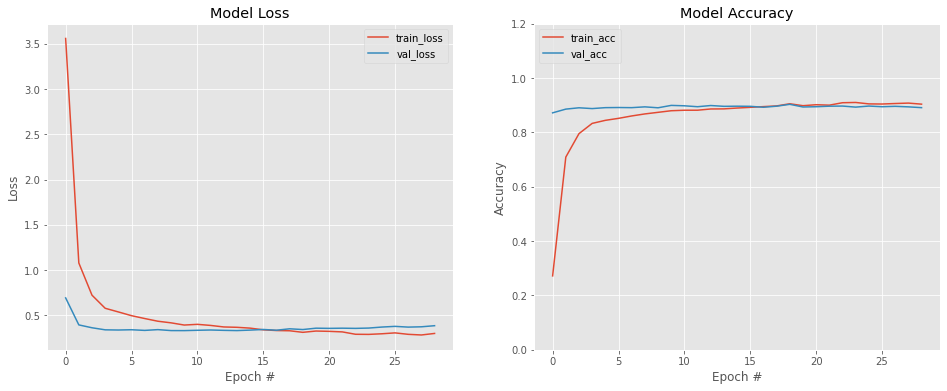


Starting fold 5
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1342 - accuracy: 0.9543


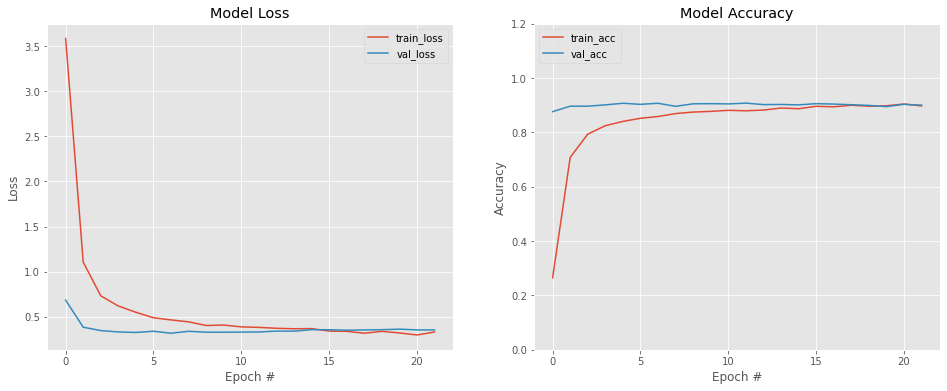


CV Score
TrainAccuracy 	avg: 0.95607 	max: 0.96637
TrainLoss 	avg: 0.13489 	min: 0.09423
ValAccuracy 	avg: 0.90286 	max: 0.90753
ValLoss 	avg: 0.32926 	min: 0.29517



In [19]:
# Test training
train_models = model_names[:3]
print(f"Feature extractions for {train_models}")
final_train_features = get_concat_features(train_models, feats_dict)

# Start training
_ = trainModels(final_train_features, Y)

## Attempt to evaluate number of models to be train

In [20]:
# list models to train for top n
list_train_models=[model_names[:i] for i in range(2, len(model_names)+1)]

# output file
cols = ["models", "ta_avg", "ta_max", "tl_avg", "tl_min", "va_avg", "va_max", "vl_avg", "vl_min"]
df_results = pd.DataFrame(columns=cols)

for train_models in list_train_models:
    print(f"Feature extractions for {train_models}")
    final_train_features = get_concat_features(train_models, feats_dict)
    trained_models, val_accuracy, val_losses, train_accuracy, train_losses = trainModels(final_train_features, Y, plot_model=False)
    
    # collect result
    result = np.array([train_models, avg(train_accuracy), max(train_accuracy), avg(train_losses), min(train_losses), avg(val_accuracy), max(val_accuracy), avg(val_losses), min(val_losses)])
    df_results=df_results.append(pd.DataFrame(result.reshape(1,-1), columns=list(df_results)),  ignore_index=True)
    df_results.to_csv("output_topN.csv")

Feature extractions for ['Xception', 'DenseNet169']

Starting fold 1
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.9456

Starting fold 2
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1613 - accuracy: 0.9562

Starting fold 3
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.2330 - accuracy: 0.9362

Starting fold 4
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1959 - accuracy: 0.9436

Starting fold 5
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1530 - accuracy: 0.9556

CV Score
TrainAccuracy 	avg: 0.94744 	max: 0.95622
TrainLoss 	avg: 0.18637 	min: 0.15298
ValAccuracy 	avg: 0.87752 	max: 0.88601
ValLoss 	avg: 0.40335 	min: 0.37272

Feature extractions for ['Xception', 'DenseNet169', 'InceptionResNetV2']

Starting fol

In [21]:
df_results.head()

,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,"[Xception, DenseNet169]",0.947442,0.956219,0.186368,0.152975,0.877519,0.886008,0.403354,0.372716
1,"[Xception, DenseNet169, InceptionResNetV2]",0.957714,0.968574,0.130232,0.096324,0.904617,0.911002,0.3307,0.306464
2,"[Xception, DenseNet169, InceptionResNetV2, Mob...",0.974687,0.987772,0.074472,0.036045,0.90315,0.908513,0.373827,0.323017
3,"[Xception, DenseNet169, InceptionResNetV2, Mob...",0.975322,0.991318,0.07442,0.023983,0.909998,0.912427,0.357257,0.313258
4,"[Xception, DenseNet169, InceptionResNetV2, Mob...",0.987747,0.992419,0.033723,0.022263,0.90403,0.908513,0.449724,0.424968


## Attempt to evaluate 5C3 Combinations

In [22]:
import itertools

# list all possible combination for 5C3
list_train_models = list(itertools.combinations(model_names[:5], 3))

for train_models in list_train_models:
    print(train_models)

('Xception', 'DenseNet169', 'InceptionResNetV2')
('Xception', 'DenseNet169', 'MobileNet')
('Xception', 'DenseNet169', 'InceptionV3')
('Xception', 'InceptionResNetV2', 'MobileNet')
('Xception', 'InceptionResNetV2', 'InceptionV3')
('Xception', 'MobileNet', 'InceptionV3')
('DenseNet169', 'InceptionResNetV2', 'MobileNet')
('DenseNet169', 'InceptionResNetV2', 'InceptionV3')
('DenseNet169', 'MobileNet', 'InceptionV3')
('InceptionResNetV2', 'MobileNet', 'InceptionV3')


In [23]:
# output file
cols = ["models", "ta_avg", "ta_max", "tl_avg", "tl_min", "va_avg", "va_max", "vl_avg", "vl_min"]
df_results = pd.DataFrame(columns=cols)

for train_models in list_train_models:
    print(f"Feature extractions for {train_models}")
    final_train_features = get_concat_features(train_models, feats_dict)
    trained_models, val_accuracy, val_losses, train_accuracy, train_losses = trainModels(final_train_features, Y, plot_model=False)
    
    # collect result
    result = np.array([train_models, avg(train_accuracy), max(train_accuracy), avg(train_losses), min(train_losses), avg(val_accuracy), max(val_accuracy), avg(val_losses), min(val_losses)])
    df_results=df_results.append(pd.DataFrame(result.reshape(1,-1), columns=list(df_results)),  ignore_index=True)
    df_results.to_csv("output_5c3.csv")

Feature extractions for ('Xception', 'DenseNet169', 'InceptionResNetV2')

Starting fold 1
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1208 - accuracy: 0.9607

Starting fold 2
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1197 - accuracy: 0.9593

Starting fold 3
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1616 - accuracy: 0.9521

Starting fold 4
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.0963 - accuracy: 0.9655

Starting fold 5
Training...
Evaluating model ...
256/256 [==============================] - 0s 2ms/step - loss: 0.1559 - accuracy: 0.9508

CV Score
TrainAccuracy 	avg: 0.95769 	max: 0.96552
TrainLoss 	avg: 0.13084 	min: 0.09626
ValAccuracy 	avg: 0.90432 	max: 0.90851
ValLoss 	avg: 0.33540 	min: 0.31490

Feature extractions for ('Xception', 'DenseNet169', 'MobileNet')


In [28]:
df_results.head(10)

,models,ta_avg,ta_max,tl_avg,tl_min,va_avg,va_max,vl_avg,vl_min
0,"(Xception, DenseNet169, InceptionResNetV2)",0.957689,0.965517,0.130842,0.096259,0.904324,0.908513,0.335402,0.314899
1,"(Xception, DenseNet169, MobileNet)",0.972388,0.979946,0.092797,0.065171,0.879965,0.885519,0.400494,0.38422
2,"(Xception, DenseNet169, InceptionV3)",0.967081,0.98496,0.102888,0.042054,0.896498,0.900244,0.367445,0.346213
3,"(Xception, InceptionResNetV2, MobileNet)",0.960208,0.970527,0.121141,0.085829,0.901291,0.905134,0.331149,0.295121
4,"(Xception, InceptionResNetV2, InceptionV3)",0.955635,0.972851,0.133268,0.075491,0.909214,0.916381,0.316058,0.269472
5,"(Xception, MobileNet, InceptionV3)",0.967986,0.982023,0.097854,0.058128,0.895226,0.901174,0.360516,0.341945
6,"(DenseNet169, InceptionResNetV2, MobileNet)",0.951502,0.969426,0.142312,0.080661,0.890041,0.89731,0.391082,0.362036
7,"(DenseNet169, InceptionResNetV2, InceptionV3)",0.952871,0.964661,0.136381,0.096228,0.905106,0.910513,0.335126,0.310287
8,"(DenseNet169, MobileNet, InceptionV3)",0.969869,0.978479,0.090005,0.061871,0.876443,0.883562,0.446616,0.407914
9,"(InceptionResNetV2, MobileNet, InceptionV3)",0.957249,0.974566,0.127211,0.074105,0.902953,0.91198,0.344215,0.314334


## Tuning (pending)

## Export testset for submission

In [25]:
# # TEST IMAGES
# test_images_list = sorted(os.listdir(os.path.join(data_dir, 'test')))
# X = []
# i = 0
# for image in tqdm.tqdm(test_images_list):

#     image_path = os.path.join(data_dir, 'test',image)
#     orig_image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
#     res_image = cv2.resize(orig_image,(img_size, img_size))
#     X.append(res_image)
#     i+=1

# Xtesarr = np.array(X)

# del(X)
# gc.collect()

# Xtesarr.shape

In [26]:
# # FEATURE EXTRACTION OF TEST IMAGES
# test_features = get_concat_features(get_valfeatures, models, preprocs, Xtesarr)

# del(Xtesarr)
# gc.collect()
# print('Final feature maps shape', test_features.shape)

In [27]:
# y_pred_norm = trained_models[0].predict(test_features, batch_size=128)/3
# for dnn in trained_models[1:]:
#     y_pred_norm += dnn.predict(test_features, batch_size=128)/3

# y_pred_norm.shape

# df.iloc[:, 1:] = y_pred_norm
# df.to_csv('submission.csv')
